<a href="https://colab.research.google.com/github/Jayaprakash1710/Computer-Vision-Ninjacart/blob/main/Ninjacart_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File link: https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing

In [3]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=508c6b21-8142-4118-904f-6d8ccf8c7221
To: /content/ninjacart_data.zip
100% 275M/275M [00:05<00:00, 47.5MB/s]


In [4]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/

In [68]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline

In [25]:
def visualize_image_counts(dataset_type='train'):
    base_path = '/content/ninjacart_data'
    folder_path = os.path.join(base_path, dataset_type)
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    total_images = sum(class_counts.values())

    # Plotting
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f"Image Count per Class in {dataset_type.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print class-wise and total count below the plot
    print("\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls} - {count}")
    print(f"Total {dataset_type} images - {total_images}")

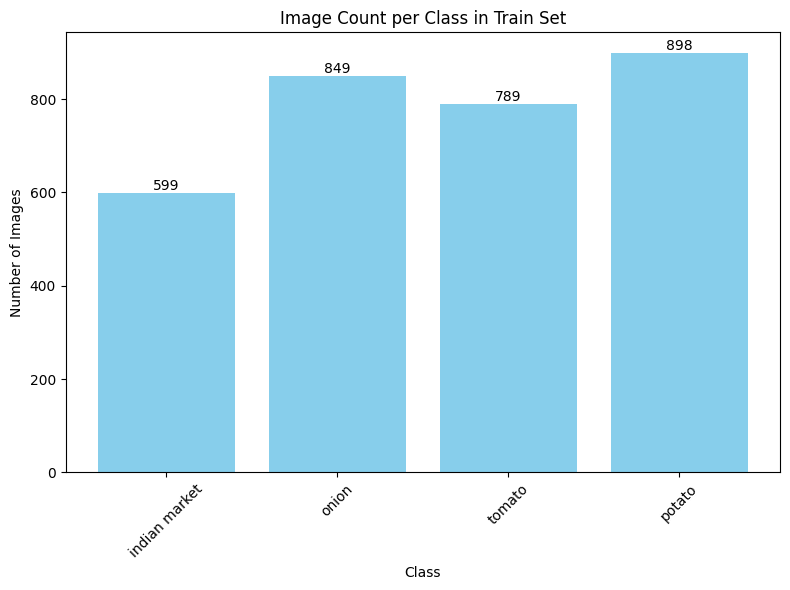


Class-wise counts:
indian market - 599
onion - 849
tomato - 789
potato - 898
Total train images - 3135


In [26]:
visualize_image_counts('train')

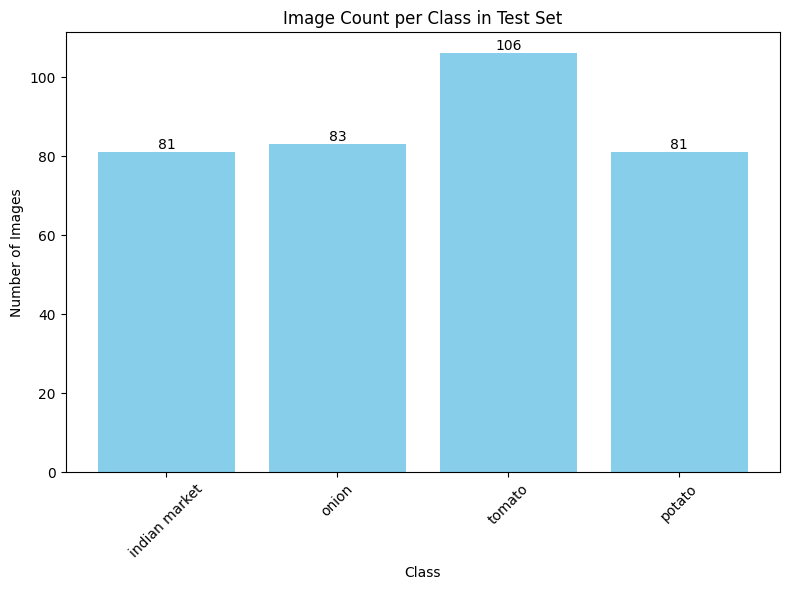


Class-wise counts:
indian market - 81
onion - 83
tomato - 106
potato - 81
Total test images - 351


In [27]:
visualize_image_counts("test")

In [28]:
def create_validation_split(train_dir='/content/ninjacart_data/train', val_dir='/content/ninjacart_data/val', val_split=0.2):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_val_path, exist_ok=True)

        images = os.listdir(class_train_path)
        random.shuffle(images)

        val_count = int(len(images) * val_split)
        val_images = images[:val_count]

        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dst_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dst_path)

    print("Validation split created.")

In [29]:
create_validation_split()

Validation split created.


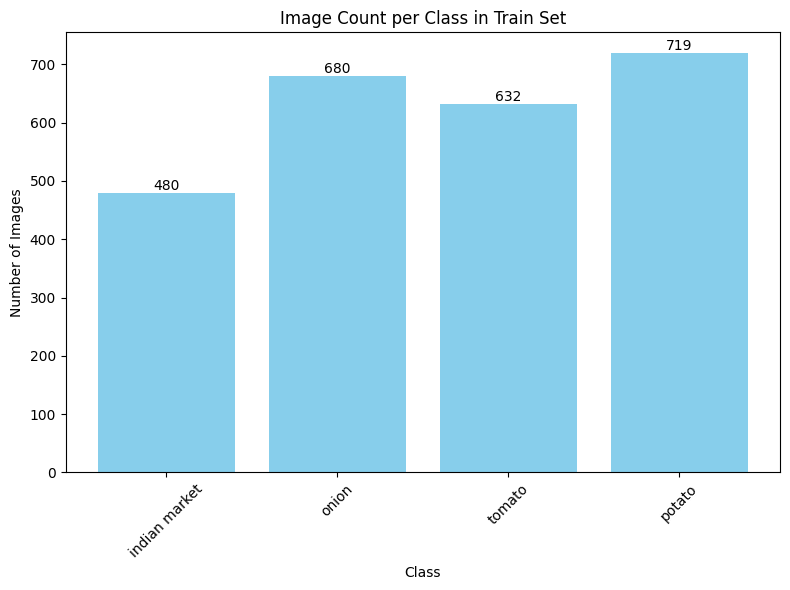


Class-wise counts:
indian market - 480
onion - 680
tomato - 632
potato - 719
Total train images - 2511


In [31]:
visualize_image_counts("train")

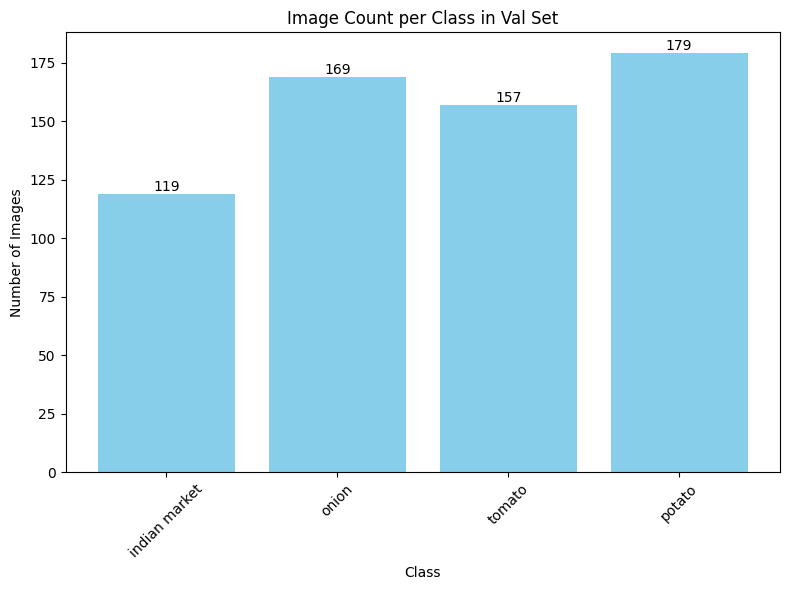


Class-wise counts:
indian market - 119
onion - 169
tomato - 157
potato - 179
Total val images - 624


In [30]:
visualize_image_counts("val")

In [37]:
def show_sample_images(train_dir='/content/ninjacart_data/train', samples_per_class=5):
    class_names = sorted(os.listdir(train_dir))
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        images = images[:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{class_name}\n{w}x{h}")
            img_index += 1

    plt.tight_layout()
    plt.show()

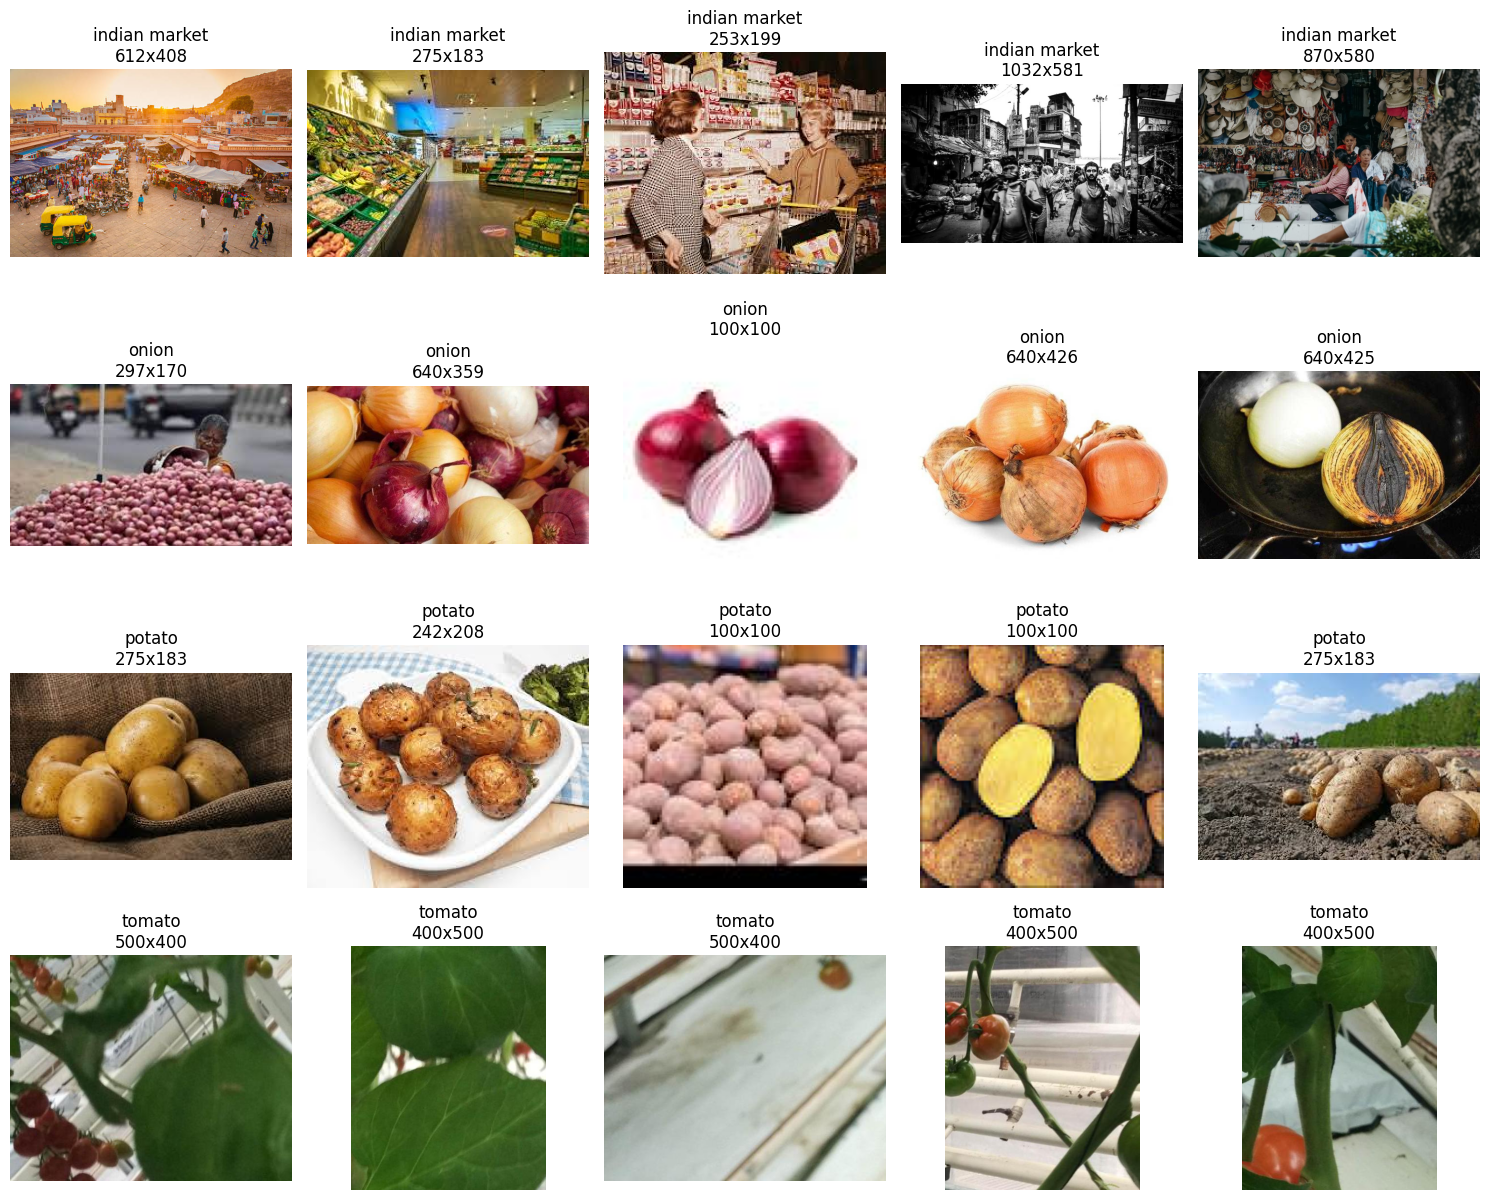

In [39]:
show_sample_images()

Resizing and Rescaling images:

In [62]:
def resize_and_rescale(base_path='/content/ninjacart_data', img_size=(128, 128), batch_size=32):
    preprocess = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ])

    def process(x, y):
        x = preprocess(x)
        y = tf.one_hot(y, depth=4)
        return x, y

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/train',
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names
    train_ds = raw_train_ds.map(process)

    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/val',
        image_size=img_size,
        batch_size=batch_size
    ).map(process)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/test',
        image_size=img_size,
        batch_size=batch_size
    ).map(process)

    return train_ds, val_ds, test_ds, class_names

In [65]:
train_ds, val_ds, test_ds,class_names = resize_and_rescale()

Found 2511 files belonging to 4 classes.
Found 624 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


#Base Line model

In [47]:
def baseline(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [48]:
model = baseline()
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,778,948 (64.01 MB)

 Trainable params: 16,778,948 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [53]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.4525 - loss: 4.1182 - val_accuracy: 0.7628 - val_loss: 0.6107
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8160 - loss: 0.5198 - val_accuracy: 0.8013 - val_loss: 0.5020
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8890 - loss: 0.3031 - val_accuracy: 0.7933 - val_loss: 0.4896
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9293 - loss: 0.2136 - val_accuracy: 0.8365 - val_loss: 0.4433
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9750 - loss: 0.1032 - val_accuracy: 0.8093 - val_loss: 0.4845
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9877 - loss: 0.0769 - val_accuracy: 0.8397 - val_loss: 0.4589
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9902 - loss: 0.0497 - val_accuracy: 0.8253 - val_loss: 0.4779
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.9926 - loss: 0.0396 - val_accuracy: 0.8349

In [54]:
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

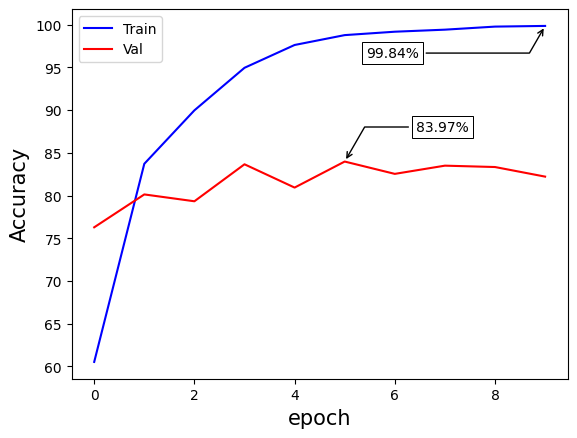

In [55]:
plot_accuracy(model_fit)

In [69]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

Test Accuracy: 26.78%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


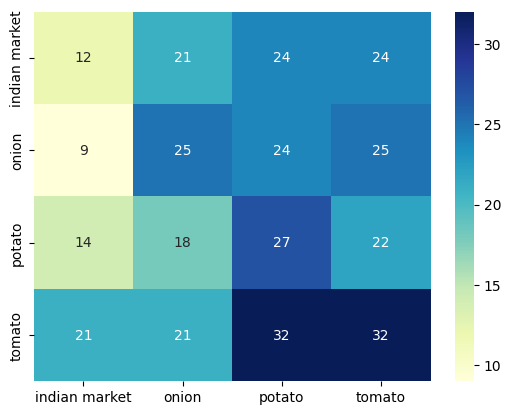

In [70]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-1

In [75]:
def arch_1(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [76]:
model = arch_1()
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,428 (1.75 MB)

 Trainable params: 459,428 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [78]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.4184 - loss: 1.1885 - val_accuracy: 0.6651 - val_loss: 0.8583
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.6964 - loss: 0.7452 - val_accuracy: 0.7949 - val_loss: 0.5226
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.7830 - loss: 0.5383 - val_accuracy: 0.8237 - val_loss: 0.4539
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.7972 - loss: 0.5244 - val_accuracy: 0.7468 - val_loss: 0.5784
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.7926 - loss: 0.5083 - val_accuracy: 0.7981 - val_loss: 0.5200
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8084 - loss: 0.4725 - val_accuracy: 0.8125 - val_loss: 0.4343
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8231 - loss: 0.4396 - val_accuracy: 0.8606 - val_loss: 0.3339
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8400 - loss: 0.3913 - val_accuracy: 0.

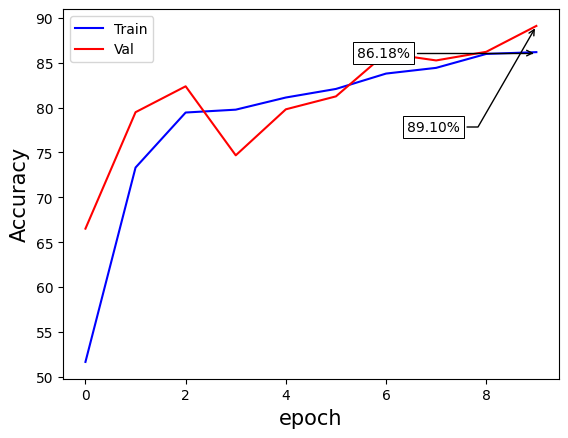

In [79]:
plot_accuracy(model_fit)

In [80]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8449 - loss: 0.4042 - val_accuracy: 0.8702 - val_loss: 0.3328
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8717 - loss: 0.3363 - val_accuracy: 0.8798 - val_loss: 0.3425
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8658 - loss: 0.3426 - val_accuracy: 0.8782 - val_loss: 0.2940
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.8844 - loss: 0.2960 - val_accuracy: 0.8798 - val_loss: 0.2756
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8920 - loss: 0.2648 - val_accuracy: 0.8958 - val_loss: 0.2754
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.8663 - loss: 0.3143 - val_accuracy: 0.8750 - val_loss: 0.2813
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8886 - loss: 0.2769 - val_accuracy: 0.8846 - val_loss: 0.2737
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9027 - loss: 0.2407 - val_accuracy: 0.8

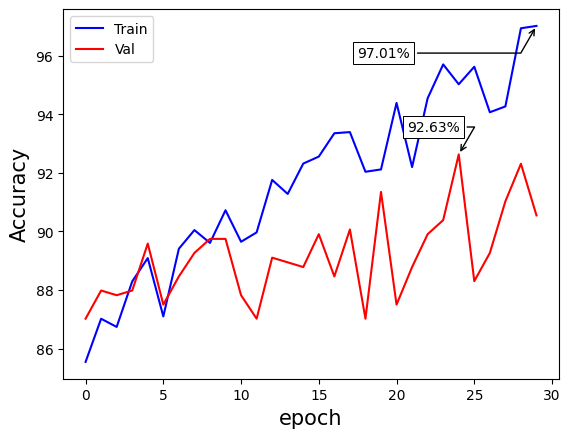

In [81]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step

Test Accuracy: 22.79%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


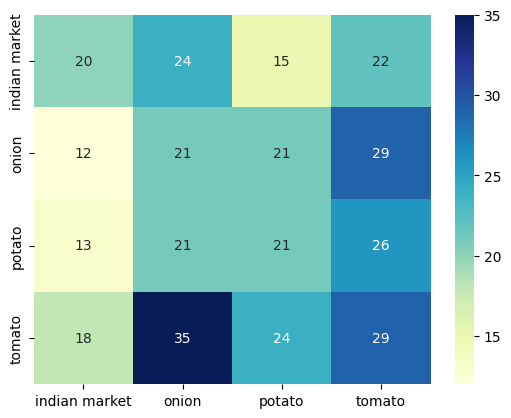

In [82]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-2

In [86]:
def arch_2(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [87]:
model = arch_2()
model.summary()

Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.6333 - loss: 1.1513 - val_accuracy: 0.4936 - val_loss: 1.6060
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.7508 - loss: 0.7195 - val_accuracy: 0.2965 - val_loss: 2.0097
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7892 - loss: 0.5864 - val_accuracy: 0.2596 - val_loss: 4.6433
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8023 - loss: 0.5532 - val_accuracy: 0.5529 - val_loss: 1.1619
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8403 - loss: 0.4384 - val_accuracy: 0.5561 - val_loss: 1.4457
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8546 - loss: 0.4110 - val_accuracy: 0.6346 - val_loss: 1.0960
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8602 - loss: 0.3656 - val_accuracy: 0.7131 - val_loss: 0.8674
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.8603 - loss: 0.3745 - val_accuracy: 0.78

In [ ]:
plot_accuracy(model_fit)

In [ ]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=5, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [ ]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-3

In [ ]:
def arch_3(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model = arch_3()
model.summary()

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)